In [1]:
#basic
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook, tqdm
%matplotlib inline
#datapreparation
import os
import scipy.io as sio
import cv2
#pytorch
import torch
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.transforms import ToTensor, Normalize, Compose, ToPILImage
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models
from torch.autograd import Variable

In [2]:
def load_image(path, pad=True):
    """
    Load image from a given path and pad it on the sides, so that eash side is divisible by 32 (newtwork requirement)
    
    if pad = True:
        returns image as numpy.array, tuple with padding in pixels as(x_min_pad, y_min_pad, x_max_pad, y_max_pad)
    else:
        returns image as numpy.array
    """
    img = cv2.imread(str(path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    if not pad:
        return img
    
    height, width, _ = img.shape
    
    if height % 32 == 0:
        y_min_pad = 0
        y_max_pad = 0
    else:
        y_pad = 32 - height % 32
        y_min_pad = int(y_pad / 2)
        y_max_pad = y_pad - y_min_pad
        
    if width % 32 == 0:
        x_min_pad = 0
        x_max_pad = 0
    else:
        x_pad = 32 - width % 32
        x_min_pad = int(x_pad / 2)
        x_max_pad = x_pad - x_min_pad
    
    img = cv2.copyMakeBorder(img, y_min_pad, y_max_pad, x_min_pad, x_max_pad, cv2.BORDER_REFLECT_101)

    return img, (x_min_pad, y_min_pad, x_max_pad, y_max_pad)

### SURREAL Dataset for pre-training.

In [3]:
class SURREALDataset(Dataset):
    def __init__(self, dirry, transforms=None, lengt=None, nclasses=True):
        self.pics = []
        subdirs = [i[0] for i in os.walk(dirry)]
        
        for i in tqdm_notebook(subdirs):
            for j in [k for k in os.listdir(i) if k.endswith('jpg')]:
                self.pics.append(i + '/' + j)
                if (len(self.pics) > lengt and lengt is not None):
                    break
        self.classes = nclasses
        self.transforms = transforms
    def __getitem__(self, i):
        
        num_classes = 25
        
        # get image and add padding to shape (x_height // 32 == 0, x_width // 32 == 0)
        x, pad = load_image(self.pics[i], pad=True)
        
        # get segmentation map
        tmp = self.pics[i].split('frame')
        mask = sio.loadmat(tmp[0] + '_segm.mat')['segm_' + str(int(tmp[1][0:-4]) + 1)]   
        y = np.zeros((num_classes, 256, 320))
        
        for i in range(len(mask)):
            row = mask[i]
            for j in range(len(row)):
                y[row[j], i, j] = 1.0

        # transorm ToTensor + add normalization to zero mean and unit std
        if self.transforms is not None:
            x = self.transforms(x)
       
        for i in range(0, 3):
            x[i] -= x[i].mean()
            
            x[i] /= x[i].std()
            
        # get all maps or only one
        if self.classes:
            y = torch.FloatTensor(y) #np.rollaxis(y, 0, 3)
        else:
            y = torch.FloatTensor(y[16].reshape(1, 256, 320)) #np.rollaxis(y, 0, 3)
        
        return x, y
    
    def __len__(self):
        return len(self.pics)
    
    def get_pics_path(self, indx):
        return self.pics[indx]

def show_pics(imgs, col, row):
    fig = plt.figure(figsize=(4*col,4*row))
    for i in range(0, col*row ):
        fig.add_subplot(row, col, i + 1)
        plt.imshow(imgs[i])

### Sitting People Dataset.

In [4]:
class SittingDataset(Dataset):
    def __init__(self, dirry, transforms=None, nclasses = True):
        self.pics = []
        for j in tqdm_notebook([k for k in os.listdir(dirry) if k.endswith('jpg')]):
            self.pics.append(dirry + '/' + j)

        self.classes = nclasses
        self.transforms = transforms
    def __getitem__(self, i):
        # get image 
        x = plt.imread(self.pics[i])
        # get segmentation map
        tmp = self.pics[i].split('img')
        mask = sio.loadmat(tmp[0] + 'masks' + tmp[-1][:-4] + '.mat')['M']   
        y = np.zeros((25, 320, 320))
        
        for i in range(len(mask)):
            row = mask[i]
            for j in range(len(row)):
                y[int(row[j]), i, j] = 1.0

        if self.transforms is not None:
            x = self.transforms(x)
       
        for i in range(0, 3):
            x[i] -= x[i].mean()
            
            x[i] /= x[i].std()
    
        if self.classes:
            y = torch.FloatTensor(y.reshape(25, 320, 320)) #np.rollaxis(y, 0, 3)
        else:
            y = torch.FloatTensor(y[1].reshape(1, 320, 320)) #np.rollaxis(y, 0, 3)
        return x, y
    
    def __len__(self):
        return len(self.pics)

In [5]:
transf = Compose([
    ToTensor(),
])

dset_train = SURREALDataset('/home/novikov/data/skoltech/segmentation/SURREAL/data/sur/SURREAL/data/cmu/train/run0', transf, 50000, False)
dset_test = SURREALDataset('/home/novikov/data/skoltech/segmentation/SURREAL/data/sur/SURREAL/data/cmu/test/run0', transf, 10000, False)
dset_val = SURREALDataset('/home/novikov/data/skoltech/segmentation/SURREAL/data/sur/SURREAL/data/cmu/val/run0', transf, 10000, False)

HBox(children=(IntProgress(value=0, max=1967), HTML(value='')))

HBox(children=(IntProgress(value=0, max=704), HTML(value='')))

HBox(children=(IntProgress(value=0, max=174), HTML(value='')))

In [6]:
batch_sz = 24
train_loader = DataLoader(dset_train, batch_size=batch_sz, shuffle=False)
test_loader = DataLoader(dset_test, batch_size=batch_sz, shuffle=True)
val_loader = DataLoader(dset_val, batch_size=batch_sz, shuffle=True)

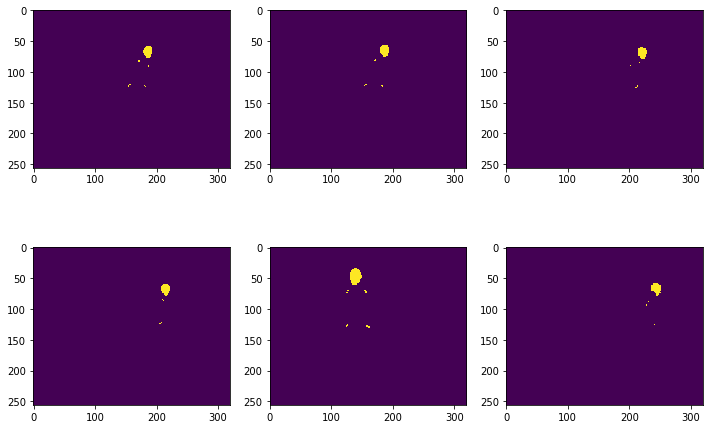

In [7]:
inputs_sur, classes_sur = next(iter(train_loader))

show_pics(classes_sur[:, 0], 3, 2)

In [8]:
dset_sitting = SittingDataset('/home/novikov/data/skoltech/segmentation/SURREAL/data/sitting/img', transf, False)
sitting_loader = DataLoader(dset_sitting, batch_size=batch_sz, shuffle=True)

HBox(children=(IntProgress(value=0, max=201), HTML(value='')))

In [9]:
inputs_sit, classes_sit = next(iter(sitting_loader))

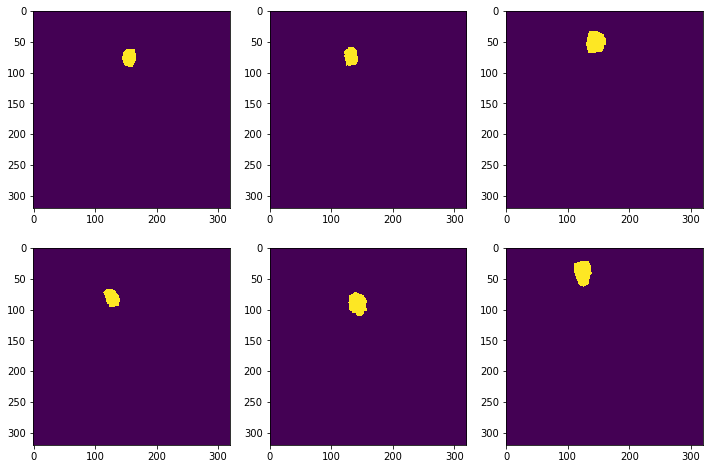

In [10]:
show_pics(classes_sit[:, 0], 3, 2)

In [12]:
#model from https://github.com/ternaus/TernausNet
def conv3x3(in_, out):
    return nn.Conv2d(in_, out, 3, padding=1)


class ConvRelu(nn.Module):
    def __init__(self, in_, out):
        super().__init__()
        self.conv = conv3x3(in_, out)
        self.activation = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.activation(x)
        return x


class DecoderBlock(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels):
        super().__init__()

        self.block = nn.Sequential(
            ConvRelu(in_channels, middle_channels),
            nn.ConvTranspose2d(middle_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.block(x)


class UNet11(nn.Module):
    def __init__(self, num_filters=32, pretrained=False):
        super().__init__()
        self.pool = nn.MaxPool2d(2, 2)

        if pretrained == 'vgg':
            self.encoder = models.vgg11(pretrained=True).features
        else:
            self.encoder = models.vgg11(pretrained=False).features

        
        self.relu = self.encoder[1]
        self.conv1 = self.encoder[0]
        self.conv2 = self.encoder[3]
        self.conv3s = self.encoder[6]
        self.conv3 = self.encoder[8]
        self.conv4s = self.encoder[11]
        self.conv4 = self.encoder[13]
        self.conv5s = self.encoder[16]
        self.conv5 = self.encoder[18]

        self.center = DecoderBlock(num_filters * 8 * 2, num_filters * 8 * 2, num_filters * 8)
        self.dec5 = DecoderBlock(num_filters * (16 + 8), num_filters * 8 * 2, num_filters * 8)
        self.dec4 = DecoderBlock(num_filters * (16 + 8), num_filters * 8 * 2, num_filters * 4)
        self.dec3 = DecoderBlock(num_filters * (8 + 4), num_filters * 4 * 2, num_filters * 2)
        self.dec2 = DecoderBlock(num_filters * (4 + 2), num_filters * 2 * 2, num_filters)
        self.dec1 = ConvRelu(num_filters * (2 + 1), num_filters)

        self.final = nn.Conv2d(num_filters, 1, kernel_size=1)

    def forward(self, x):
        conv1 = self.relu(self.conv1(x))
        conv2 = self.relu(self.conv2(self.pool(conv1)))
        conv3s = self.relu(self.conv3s(self.pool(conv2)))
        conv3 = self.relu(self.conv3(conv3s))
        conv4s = self.relu(self.conv4s(self.pool(conv3)))
        conv4 = self.relu(self.conv4(conv4s))
        conv5s = self.relu(self.conv5s(self.pool(conv4)))
        conv5 = self.relu(self.conv5(conv5s))

        center = self.center(self.pool(conv5))

        dec5 = self.dec5(torch.cat([center, conv5], 1))
        dec4 = self.dec4(torch.cat([dec5, conv4], 1))
        dec3 = self.dec3(torch.cat([dec4, conv3], 1))
        dec2 = self.dec2(torch.cat([dec3, conv2], 1))
        dec1 = self.dec1(torch.cat([dec2, conv1], 1))
        return F.sigmoid(self.final(dec1))


def unet11(pretrained=False, path='', **kwargs):
    model = UNet11(pretrained=pretrained, **kwargs)

    if pretrained == 'carvana':
        state = torch.load('TernausNet.pt')
        model.load_state_dict(state['model'])
    
    if pretrained == 'trained_recently':
        state = torch.load(path)
        model.load_state_dict(state)
    return model

In [13]:
def soft_dice_loss(inputs, targets):
    num = targets.size(0)
    m1  = inputs.view(num,-1)
    m2  = targets.view(num,-1)
    intersection = (m1 * m2)
    score = 2. * (intersection.sum(1)+1) / (m1.sum(1) + m2.sum(1)+1)
    score = 1 - score.sum()/num
    return score
def jaccard_loss(inputs, targets):
    #J = Dice / (2 - Dice)
    return soft_dice_loss(inputs, targets) / (2 - soft_dice_loss(inputs, targets))
def L_loss(inputs, targets):
    return F.binary_cross_entropy(inputs, targets) - torch.log(jaccard_loss(inputs, targets))

In [13]:
model = unet11('carvana')
#model = unet11('trained_recently', path='pytorch_segm_model_normalized')

In [14]:
#optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001, momentum=0.5)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.5, nesterov=True)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    patience=1,
    verbose=True,
    threshold=0.01
)

In [15]:
def train(epoch, gpu=False):
    model.train()
    if gpu == True:
        model.cuda()
    loss_tr = []
    
    for batch_idx, (data, target) in (enumerate(train_loader)):
    
        if gpu == True:
            data, target = data.cuda(async=True), target.cuda(async=True) # On GPU
        
        data, target = torch.unsqueeze(Variable(data), dim=0)[0], Variable(target)
        
        optimizer.zero_grad()
        
# Simple summ of losses:
        loss_1 = F.binary_cross_entropy(model(data), target)
        loss_2 = soft_dice_loss(model(data), target)
        loss = loss_1 + loss_2
        loss_tr.append([loss_1.data[0], loss_2.data[0]])

# Joint loss https://arxiv.org/pdf/1706.06169.pdf
#         loss = L_loss(model(data), target)
#         loss_tr.append(loss.data[0])
        loss.backward()
        
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: BinaryCrossEntropyLoss {:.5f}, SoftDiceLoss {:.5f}, SumLoss {:.5f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss_1.data[0], loss_2.data[0], loss.data[0]))
    
    return loss_tr

def validate(gpu=False):
    model.eval()
    if gpu == True:
        model.cuda()
    val_loss = []
    
    for batch_idx, (data, target) in (enumerate(val_loader)):
       
        if gpu == True:
            data, target = data.cuda(async=True), target.cuda(async=True) # On GPU
       
        data, target = torch.unsqueeze(Variable(data), dim=0)[0], Variable(target)
        
        optimizer.zero_grad()
        
# Simple summ of losses:
        #loss_1 = F.binary_cross_entropy(model(data), target)
        #loss_2 = soft_dice_loss(model(data), target)      
        val_loss.append(F.binary_cross_entropy(model(data), target).data[0] + soft_dice_loss(model(data), target).data[0])

# Joint loss
#         loss = L_loss(model(data), target)
#         val_loss.append(loss.data[0])
        
    val_loss.append(np.mean(val_loss))
    scheduler.step(val_loss[-1])
    print('Loss on validation:', val_loss[-1])
    return val_loss[-1]

In [16]:
loss_tr = []
loss_val = []
gpu = torch.cuda.is_available()
for epoch in range(15):
    loss_tr.append(train(epoch, gpu))
    loss_val.append(validate(gpu))
    torch.save(model.state_dict(), 'pytorch_segm_model_sum_loss')
torch.save(model.state_dict(), 'pytorch_segm_model_sum_loss_final')

Train Epoch: 0 [0/51892 (0%)]	Loss: BinaryCrossEntropyLoss 7.40798, SoftDiceLoss 0.98859, SumLoss 8.39657
Train Epoch: 0 [240/51892 (0%)]	Loss: BinaryCrossEntropyLoss 0.28462, SoftDiceLoss 0.98014, SumLoss 1.26476
Train Epoch: 0 [480/51892 (1%)]	Loss: BinaryCrossEntropyLoss 0.21171, SoftDiceLoss 0.98803, SumLoss 1.19974
Train Epoch: 0 [720/51892 (1%)]	Loss: BinaryCrossEntropyLoss 0.06901, SoftDiceLoss 0.99233, SumLoss 1.06134
Train Epoch: 0 [960/51892 (2%)]	Loss: BinaryCrossEntropyLoss 0.05420, SoftDiceLoss 0.98145, SumLoss 1.03564
Train Epoch: 0 [1200/51892 (2%)]	Loss: BinaryCrossEntropyLoss 0.04801, SoftDiceLoss 0.97945, SumLoss 1.02745
Train Epoch: 0 [1440/51892 (3%)]	Loss: BinaryCrossEntropyLoss 0.04850, SoftDiceLoss 0.97665, SumLoss 1.02515
Train Epoch: 0 [1680/51892 (3%)]	Loss: BinaryCrossEntropyLoss 0.03854, SoftDiceLoss 0.97010, SumLoss 1.00864
Train Epoch: 0 [1920/51892 (4%)]	Loss: BinaryCrossEntropyLoss 0.04644, SoftDiceLoss 0.97194, SumLoss 1.01838
Train Epoch: 0 [2160/51892

Train Epoch: 0 [18000/51892 (35%)]	Loss: BinaryCrossEntropyLoss 0.02332, SoftDiceLoss 0.58685, SumLoss 0.61017
Train Epoch: 0 [18240/51892 (35%)]	Loss: BinaryCrossEntropyLoss 0.01387, SoftDiceLoss 0.46283, SumLoss 0.47669
Train Epoch: 0 [18480/51892 (36%)]	Loss: BinaryCrossEntropyLoss 0.01410, SoftDiceLoss 0.41866, SumLoss 0.43275
Train Epoch: 0 [18720/51892 (36%)]	Loss: BinaryCrossEntropyLoss 0.01430, SoftDiceLoss 0.38916, SumLoss 0.40347
Train Epoch: 0 [18960/51892 (37%)]	Loss: BinaryCrossEntropyLoss 0.01893, SoftDiceLoss 0.42239, SumLoss 0.44132
Train Epoch: 0 [19200/51892 (37%)]	Loss: BinaryCrossEntropyLoss 0.02899, SoftDiceLoss 0.56868, SumLoss 0.59767
Train Epoch: 0 [19440/51892 (37%)]	Loss: BinaryCrossEntropyLoss 0.01999, SoftDiceLoss 0.46955, SumLoss 0.48954
Train Epoch: 0 [19680/51892 (38%)]	Loss: BinaryCrossEntropyLoss 0.01616, SoftDiceLoss 0.38993, SumLoss 0.40609
Train Epoch: 0 [19920/51892 (38%)]	Loss: BinaryCrossEntropyLoss 0.01524, SoftDiceLoss 0.37654, SumLoss 0.39178
T

Train Epoch: 0 [35760/51892 (69%)]	Loss: BinaryCrossEntropyLoss 0.01567, SoftDiceLoss 0.38762, SumLoss 0.40329
Train Epoch: 0 [36000/51892 (69%)]	Loss: BinaryCrossEntropyLoss 0.01986, SoftDiceLoss 0.25048, SumLoss 0.27034
Train Epoch: 0 [36240/51892 (70%)]	Loss: BinaryCrossEntropyLoss 0.02184, SoftDiceLoss 0.48064, SumLoss 0.50248
Train Epoch: 0 [36480/51892 (70%)]	Loss: BinaryCrossEntropyLoss 0.02291, SoftDiceLoss 0.48645, SumLoss 0.50935
Train Epoch: 0 [36720/51892 (71%)]	Loss: BinaryCrossEntropyLoss 0.02021, SoftDiceLoss 0.51446, SumLoss 0.53467
Train Epoch: 0 [36960/51892 (71%)]	Loss: BinaryCrossEntropyLoss 0.02039, SoftDiceLoss 0.44243, SumLoss 0.46282
Train Epoch: 0 [37200/51892 (72%)]	Loss: BinaryCrossEntropyLoss 0.02842, SoftDiceLoss 0.70437, SumLoss 0.73279
Train Epoch: 0 [37440/51892 (72%)]	Loss: BinaryCrossEntropyLoss 0.02506, SoftDiceLoss 0.75230, SumLoss 0.77736
Train Epoch: 0 [37680/51892 (73%)]	Loss: BinaryCrossEntropyLoss 0.01874, SoftDiceLoss 0.63318, SumLoss 0.65192
T

Train Epoch: 1 [1440/51892 (3%)]	Loss: BinaryCrossEntropyLoss 0.00964, SoftDiceLoss 0.22965, SumLoss 0.23929
Train Epoch: 1 [1680/51892 (3%)]	Loss: BinaryCrossEntropyLoss 0.00881, SoftDiceLoss 0.22407, SumLoss 0.23288
Train Epoch: 1 [1920/51892 (4%)]	Loss: BinaryCrossEntropyLoss 0.00945, SoftDiceLoss 0.20083, SumLoss 0.21028
Train Epoch: 1 [2160/51892 (4%)]	Loss: BinaryCrossEntropyLoss 0.00829, SoftDiceLoss 0.22338, SumLoss 0.23167
Train Epoch: 1 [2400/51892 (5%)]	Loss: BinaryCrossEntropyLoss 0.00945, SoftDiceLoss 0.22617, SumLoss 0.23562
Train Epoch: 1 [2640/51892 (5%)]	Loss: BinaryCrossEntropyLoss 0.01580, SoftDiceLoss 0.32443, SumLoss 0.34023
Train Epoch: 1 [2880/51892 (6%)]	Loss: BinaryCrossEntropyLoss 0.01536, SoftDiceLoss 0.32954, SumLoss 0.34490
Train Epoch: 1 [3120/51892 (6%)]	Loss: BinaryCrossEntropyLoss 0.02943, SoftDiceLoss 0.62725, SumLoss 0.65668
Train Epoch: 1 [3360/51892 (6%)]	Loss: BinaryCrossEntropyLoss 0.01048, SoftDiceLoss 0.25419, SumLoss 0.26467
Train Epoch: 1 [360

Train Epoch: 1 [19440/51892 (37%)]	Loss: BinaryCrossEntropyLoss 0.01243, SoftDiceLoss 0.24683, SumLoss 0.25926
Train Epoch: 1 [19680/51892 (38%)]	Loss: BinaryCrossEntropyLoss 0.01429, SoftDiceLoss 0.23671, SumLoss 0.25100
Train Epoch: 1 [19920/51892 (38%)]	Loss: BinaryCrossEntropyLoss 0.01246, SoftDiceLoss 0.22358, SumLoss 0.23604
Train Epoch: 1 [20160/51892 (39%)]	Loss: BinaryCrossEntropyLoss 0.01368, SoftDiceLoss 0.21736, SumLoss 0.23104
Train Epoch: 1 [20400/51892 (39%)]	Loss: BinaryCrossEntropyLoss 0.01300, SoftDiceLoss 0.22254, SumLoss 0.23554
Train Epoch: 1 [20640/51892 (40%)]	Loss: BinaryCrossEntropyLoss 0.01313, SoftDiceLoss 0.19274, SumLoss 0.20587
Train Epoch: 1 [20880/51892 (40%)]	Loss: BinaryCrossEntropyLoss 0.01230, SoftDiceLoss 0.18241, SumLoss 0.19471
Train Epoch: 1 [21120/51892 (41%)]	Loss: BinaryCrossEntropyLoss 0.01187, SoftDiceLoss 0.17443, SumLoss 0.18630
Train Epoch: 1 [21360/51892 (41%)]	Loss: BinaryCrossEntropyLoss 0.01351, SoftDiceLoss 0.19169, SumLoss 0.20519
T

Train Epoch: 1 [37200/51892 (72%)]	Loss: BinaryCrossEntropyLoss 0.02458, SoftDiceLoss 0.63260, SumLoss 0.65718
Train Epoch: 1 [37440/51892 (72%)]	Loss: BinaryCrossEntropyLoss 0.02182, SoftDiceLoss 0.68863, SumLoss 0.71045
Train Epoch: 1 [37680/51892 (73%)]	Loss: BinaryCrossEntropyLoss 0.01613, SoftDiceLoss 0.54241, SumLoss 0.55855
Train Epoch: 1 [37920/51892 (73%)]	Loss: BinaryCrossEntropyLoss 0.01450, SoftDiceLoss 0.52289, SumLoss 0.53740
Train Epoch: 1 [38160/51892 (74%)]	Loss: BinaryCrossEntropyLoss 0.01970, SoftDiceLoss 0.51723, SumLoss 0.53693
Train Epoch: 1 [38400/51892 (74%)]	Loss: BinaryCrossEntropyLoss 0.02014, SoftDiceLoss 0.32711, SumLoss 0.34725
Train Epoch: 1 [38640/51892 (74%)]	Loss: BinaryCrossEntropyLoss 0.01185, SoftDiceLoss 0.25108, SumLoss 0.26293
Train Epoch: 1 [38880/51892 (75%)]	Loss: BinaryCrossEntropyLoss 0.01359, SoftDiceLoss 0.26644, SumLoss 0.28002
Train Epoch: 1 [39120/51892 (75%)]	Loss: BinaryCrossEntropyLoss 0.01108, SoftDiceLoss 0.31028, SumLoss 0.32136
T

Train Epoch: 2 [2880/51892 (6%)]	Loss: BinaryCrossEntropyLoss 0.01461, SoftDiceLoss 0.31121, SumLoss 0.32582
Train Epoch: 2 [3120/51892 (6%)]	Loss: BinaryCrossEntropyLoss 0.02504, SoftDiceLoss 0.54732, SumLoss 0.57237
Train Epoch: 2 [3360/51892 (6%)]	Loss: BinaryCrossEntropyLoss 0.00899, SoftDiceLoss 0.20853, SumLoss 0.21752
Train Epoch: 2 [3600/51892 (7%)]	Loss: BinaryCrossEntropyLoss 0.00839, SoftDiceLoss 0.23484, SumLoss 0.24323
Train Epoch: 2 [3840/51892 (7%)]	Loss: BinaryCrossEntropyLoss 0.01750, SoftDiceLoss 0.31663, SumLoss 0.33413
Train Epoch: 2 [4080/51892 (8%)]	Loss: BinaryCrossEntropyLoss 0.01452, SoftDiceLoss 0.26560, SumLoss 0.28012
Train Epoch: 2 [4320/51892 (8%)]	Loss: BinaryCrossEntropyLoss 0.01514, SoftDiceLoss 0.14553, SumLoss 0.16067
Train Epoch: 2 [4560/51892 (9%)]	Loss: BinaryCrossEntropyLoss 0.01981, SoftDiceLoss 0.22943, SumLoss 0.24924
Train Epoch: 2 [4800/51892 (9%)]	Loss: BinaryCrossEntropyLoss 0.01298, SoftDiceLoss 0.10096, SumLoss 0.11395
Train Epoch: 2 [504

Train Epoch: 2 [20880/51892 (40%)]	Loss: BinaryCrossEntropyLoss 0.01140, SoftDiceLoss 0.17111, SumLoss 0.18251
Train Epoch: 2 [21120/51892 (41%)]	Loss: BinaryCrossEntropyLoss 0.01084, SoftDiceLoss 0.16010, SumLoss 0.17094
Train Epoch: 2 [21360/51892 (41%)]	Loss: BinaryCrossEntropyLoss 0.01238, SoftDiceLoss 0.17485, SumLoss 0.18723
Train Epoch: 2 [21600/51892 (42%)]	Loss: BinaryCrossEntropyLoss 0.01263, SoftDiceLoss 0.16947, SumLoss 0.18210
Train Epoch: 2 [21840/51892 (42%)]	Loss: BinaryCrossEntropyLoss 0.01088, SoftDiceLoss 0.08209, SumLoss 0.09297
Train Epoch: 2 [22080/51892 (43%)]	Loss: BinaryCrossEntropyLoss 0.01021, SoftDiceLoss 0.17051, SumLoss 0.18072
Train Epoch: 2 [22320/51892 (43%)]	Loss: BinaryCrossEntropyLoss 0.01322, SoftDiceLoss 0.31374, SumLoss 0.32696
Train Epoch: 2 [22560/51892 (43%)]	Loss: BinaryCrossEntropyLoss 0.01015, SoftDiceLoss 0.23464, SumLoss 0.24479
Train Epoch: 2 [22800/51892 (44%)]	Loss: BinaryCrossEntropyLoss 0.00908, SoftDiceLoss 0.24237, SumLoss 0.25145
T

Train Epoch: 2 [38640/51892 (74%)]	Loss: BinaryCrossEntropyLoss 0.01151, SoftDiceLoss 0.23807, SumLoss 0.24958
Train Epoch: 2 [38880/51892 (75%)]	Loss: BinaryCrossEntropyLoss 0.01302, SoftDiceLoss 0.25035, SumLoss 0.26336
Train Epoch: 2 [39120/51892 (75%)]	Loss: BinaryCrossEntropyLoss 0.00832, SoftDiceLoss 0.23953, SumLoss 0.24785
Train Epoch: 2 [39360/51892 (76%)]	Loss: BinaryCrossEntropyLoss 0.00842, SoftDiceLoss 0.19759, SumLoss 0.20601
Train Epoch: 2 [39600/51892 (76%)]	Loss: BinaryCrossEntropyLoss 0.00733, SoftDiceLoss 0.19444, SumLoss 0.20176
Train Epoch: 2 [39840/51892 (77%)]	Loss: BinaryCrossEntropyLoss 0.00822, SoftDiceLoss 0.21605, SumLoss 0.22427
Train Epoch: 2 [40080/51892 (77%)]	Loss: BinaryCrossEntropyLoss 0.00577, SoftDiceLoss 0.19535, SumLoss 0.20112
Train Epoch: 2 [40320/51892 (78%)]	Loss: BinaryCrossEntropyLoss 0.01259, SoftDiceLoss 0.03447, SumLoss 0.04706
Train Epoch: 2 [40560/51892 (78%)]	Loss: BinaryCrossEntropyLoss 0.01054, SoftDiceLoss 0.19940, SumLoss 0.20993
T

Train Epoch: 3 [4320/51892 (8%)]	Loss: BinaryCrossEntropyLoss 0.01355, SoftDiceLoss 0.12219, SumLoss 0.13575
Train Epoch: 3 [4560/51892 (9%)]	Loss: BinaryCrossEntropyLoss 0.01859, SoftDiceLoss 0.21728, SumLoss 0.23586
Train Epoch: 3 [4800/51892 (9%)]	Loss: BinaryCrossEntropyLoss 0.01232, SoftDiceLoss 0.08949, SumLoss 0.10181
Train Epoch: 3 [5040/51892 (10%)]	Loss: BinaryCrossEntropyLoss 0.02233, SoftDiceLoss 0.35924, SumLoss 0.38157
Train Epoch: 3 [5280/51892 (10%)]	Loss: BinaryCrossEntropyLoss 0.01880, SoftDiceLoss 0.23665, SumLoss 0.25546
Train Epoch: 3 [5520/51892 (11%)]	Loss: BinaryCrossEntropyLoss 0.01544, SoftDiceLoss 0.22493, SumLoss 0.24037
Train Epoch: 3 [5760/51892 (11%)]	Loss: BinaryCrossEntropyLoss 0.01533, SoftDiceLoss 0.29304, SumLoss 0.30837
Train Epoch: 3 [6000/51892 (12%)]	Loss: BinaryCrossEntropyLoss 0.01594, SoftDiceLoss 0.24482, SumLoss 0.26076
Train Epoch: 3 [6240/51892 (12%)]	Loss: BinaryCrossEntropyLoss 0.01143, SoftDiceLoss 0.11949, SumLoss 0.13091
Train Epoch: 

Train Epoch: 3 [22320/51892 (43%)]	Loss: BinaryCrossEntropyLoss 0.00854, SoftDiceLoss 0.22996, SumLoss 0.23849
Train Epoch: 3 [22560/51892 (43%)]	Loss: BinaryCrossEntropyLoss 0.00933, SoftDiceLoss 0.20648, SumLoss 0.21581
Train Epoch: 3 [22800/51892 (44%)]	Loss: BinaryCrossEntropyLoss 0.00807, SoftDiceLoss 0.21106, SumLoss 0.21913
Train Epoch: 3 [23040/51892 (44%)]	Loss: BinaryCrossEntropyLoss 0.00991, SoftDiceLoss 0.19307, SumLoss 0.20298
Train Epoch: 3 [23280/51892 (45%)]	Loss: BinaryCrossEntropyLoss 0.00821, SoftDiceLoss 0.13285, SumLoss 0.14106
Train Epoch: 3 [23520/51892 (45%)]	Loss: BinaryCrossEntropyLoss 0.00864, SoftDiceLoss 0.19576, SumLoss 0.20440
Train Epoch: 3 [23760/51892 (46%)]	Loss: BinaryCrossEntropyLoss 0.00987, SoftDiceLoss 0.21094, SumLoss 0.22081
Train Epoch: 3 [24000/51892 (46%)]	Loss: BinaryCrossEntropyLoss 0.00907, SoftDiceLoss 0.18816, SumLoss 0.19722
Train Epoch: 3 [24240/51892 (47%)]	Loss: BinaryCrossEntropyLoss 0.00739, SoftDiceLoss 0.17917, SumLoss 0.18656
T

Train Epoch: 3 [40080/51892 (77%)]	Loss: BinaryCrossEntropyLoss 0.00553, SoftDiceLoss 0.18463, SumLoss 0.19016
Train Epoch: 3 [40320/51892 (78%)]	Loss: BinaryCrossEntropyLoss 0.01074, SoftDiceLoss 0.01199, SumLoss 0.02273
Train Epoch: 3 [40560/51892 (78%)]	Loss: BinaryCrossEntropyLoss 0.00997, SoftDiceLoss 0.18529, SumLoss 0.19526
Train Epoch: 3 [40800/51892 (79%)]	Loss: BinaryCrossEntropyLoss 0.00963, SoftDiceLoss 0.21710, SumLoss 0.22673
Train Epoch: 3 [41040/51892 (79%)]	Loss: BinaryCrossEntropyLoss 0.00976, SoftDiceLoss 0.18358, SumLoss 0.19334
Train Epoch: 3 [41280/51892 (80%)]	Loss: BinaryCrossEntropyLoss 0.01078, SoftDiceLoss 0.18075, SumLoss 0.19153
Train Epoch: 3 [41520/51892 (80%)]	Loss: BinaryCrossEntropyLoss 0.01083, SoftDiceLoss 0.23138, SumLoss 0.24221
Train Epoch: 3 [41760/51892 (80%)]	Loss: BinaryCrossEntropyLoss 0.01126, SoftDiceLoss 0.11962, SumLoss 0.13088
Train Epoch: 3 [42000/51892 (81%)]	Loss: BinaryCrossEntropyLoss 0.01229, SoftDiceLoss 0.20218, SumLoss 0.21447
T

Train Epoch: 4 [5760/51892 (11%)]	Loss: BinaryCrossEntropyLoss 0.01397, SoftDiceLoss 0.27412, SumLoss 0.28809
Train Epoch: 4 [6000/51892 (12%)]	Loss: BinaryCrossEntropyLoss 0.01493, SoftDiceLoss 0.22986, SumLoss 0.24479
Train Epoch: 4 [6240/51892 (12%)]	Loss: BinaryCrossEntropyLoss 0.01085, SoftDiceLoss 0.10444, SumLoss 0.11529
Train Epoch: 4 [6480/51892 (12%)]	Loss: BinaryCrossEntropyLoss 0.01159, SoftDiceLoss 0.18511, SumLoss 0.19671
Train Epoch: 4 [6720/51892 (13%)]	Loss: BinaryCrossEntropyLoss 0.01903, SoftDiceLoss 0.21596, SumLoss 0.23500
Train Epoch: 4 [6960/51892 (13%)]	Loss: BinaryCrossEntropyLoss 0.00807, SoftDiceLoss 0.19643, SumLoss 0.20451
Train Epoch: 4 [7200/51892 (14%)]	Loss: BinaryCrossEntropyLoss 0.00880, SoftDiceLoss 0.18269, SumLoss 0.19149
Train Epoch: 4 [7440/51892 (14%)]	Loss: BinaryCrossEntropyLoss 0.00826, SoftDiceLoss -0.00073, SumLoss 0.00753
Train Epoch: 4 [7680/51892 (15%)]	Loss: BinaryCrossEntropyLoss 0.01050, SoftDiceLoss 0.23159, SumLoss 0.24209
Train Epo

Train Epoch: 4 [23520/51892 (45%)]	Loss: BinaryCrossEntropyLoss 0.00838, SoftDiceLoss 0.18863, SumLoss 0.19701
Train Epoch: 4 [23760/51892 (46%)]	Loss: BinaryCrossEntropyLoss 0.00954, SoftDiceLoss 0.20324, SumLoss 0.21277
Train Epoch: 4 [24000/51892 (46%)]	Loss: BinaryCrossEntropyLoss 0.00872, SoftDiceLoss 0.18090, SumLoss 0.18962
Train Epoch: 4 [24240/51892 (47%)]	Loss: BinaryCrossEntropyLoss 0.00713, SoftDiceLoss 0.17321, SumLoss 0.18034
Train Epoch: 4 [24480/51892 (47%)]	Loss: BinaryCrossEntropyLoss 0.01021, SoftDiceLoss 0.19240, SumLoss 0.20261
Train Epoch: 4 [24720/51892 (48%)]	Loss: BinaryCrossEntropyLoss 0.00970, SoftDiceLoss 0.17555, SumLoss 0.18525
Train Epoch: 4 [24960/51892 (48%)]	Loss: BinaryCrossEntropyLoss 0.00861, SoftDiceLoss 0.21318, SumLoss 0.22178
Train Epoch: 4 [25200/51892 (49%)]	Loss: BinaryCrossEntropyLoss 0.00918, SoftDiceLoss 0.12986, SumLoss 0.13904
Train Epoch: 4 [25440/51892 (49%)]	Loss: BinaryCrossEntropyLoss 0.00768, SoftDiceLoss 0.18042, SumLoss 0.18810
T

Train Epoch: 4 [41280/51892 (80%)]	Loss: BinaryCrossEntropyLoss 0.01054, SoftDiceLoss 0.17550, SumLoss 0.18604
Train Epoch: 4 [41520/51892 (80%)]	Loss: BinaryCrossEntropyLoss 0.01037, SoftDiceLoss 0.21814, SumLoss 0.22851
Train Epoch: 4 [41760/51892 (80%)]	Loss: BinaryCrossEntropyLoss 0.01089, SoftDiceLoss 0.11684, SumLoss 0.12773
Train Epoch: 4 [42000/51892 (81%)]	Loss: BinaryCrossEntropyLoss 0.01182, SoftDiceLoss 0.19629, SumLoss 0.20811
Train Epoch: 4 [42240/51892 (81%)]	Loss: BinaryCrossEntropyLoss 0.01394, SoftDiceLoss 0.18261, SumLoss 0.19655
Train Epoch: 4 [42480/51892 (82%)]	Loss: BinaryCrossEntropyLoss 0.00817, SoftDiceLoss 0.17401, SumLoss 0.18217
Train Epoch: 4 [42720/51892 (82%)]	Loss: BinaryCrossEntropyLoss 0.00854, SoftDiceLoss 0.17433, SumLoss 0.18286
Train Epoch: 4 [42960/51892 (83%)]	Loss: BinaryCrossEntropyLoss 0.00866, SoftDiceLoss 0.18161, SumLoss 0.19027
Train Epoch: 4 [43200/51892 (83%)]	Loss: BinaryCrossEntropyLoss 0.00613, SoftDiceLoss 0.15409, SumLoss 0.16022
T

Train Epoch: 5 [6960/51892 (13%)]	Loss: BinaryCrossEntropyLoss 0.00796, SoftDiceLoss 0.19207, SumLoss 0.20003
Train Epoch: 5 [7200/51892 (14%)]	Loss: BinaryCrossEntropyLoss 0.00858, SoftDiceLoss 0.17494, SumLoss 0.18353
Train Epoch: 5 [7440/51892 (14%)]	Loss: BinaryCrossEntropyLoss 0.00790, SoftDiceLoss -0.00607, SumLoss 0.00182
Train Epoch: 5 [7680/51892 (15%)]	Loss: BinaryCrossEntropyLoss 0.01018, SoftDiceLoss 0.22510, SumLoss 0.23528
Train Epoch: 5 [7920/51892 (15%)]	Loss: BinaryCrossEntropyLoss 0.00991, SoftDiceLoss 0.20322, SumLoss 0.21312
Train Epoch: 5 [8160/51892 (16%)]	Loss: BinaryCrossEntropyLoss 0.01601, SoftDiceLoss 0.19419, SumLoss 0.21020
Train Epoch: 5 [8400/51892 (16%)]	Loss: BinaryCrossEntropyLoss 0.01752, SoftDiceLoss 0.17624, SumLoss 0.19376
Train Epoch: 5 [8640/51892 (17%)]	Loss: BinaryCrossEntropyLoss 0.01222, SoftDiceLoss 0.18223, SumLoss 0.19445
Train Epoch: 5 [8880/51892 (17%)]	Loss: BinaryCrossEntropyLoss 0.00651, SoftDiceLoss 0.14957, SumLoss 0.15608
Train Epo

Train Epoch: 5 [24720/51892 (48%)]	Loss: BinaryCrossEntropyLoss 0.00936, SoftDiceLoss 0.17070, SumLoss 0.18006
Train Epoch: 5 [24960/51892 (48%)]	Loss: BinaryCrossEntropyLoss 0.00836, SoftDiceLoss 0.20885, SumLoss 0.21721
Train Epoch: 5 [25200/51892 (49%)]	Loss: BinaryCrossEntropyLoss 0.00884, SoftDiceLoss 0.12409, SumLoss 0.13293
Train Epoch: 5 [25440/51892 (49%)]	Loss: BinaryCrossEntropyLoss 0.00739, SoftDiceLoss 0.17414, SumLoss 0.18154
Train Epoch: 5 [25680/51892 (49%)]	Loss: BinaryCrossEntropyLoss 0.01127, SoftDiceLoss 0.32212, SumLoss 0.33339
Train Epoch: 5 [25920/51892 (50%)]	Loss: BinaryCrossEntropyLoss 0.00679, SoftDiceLoss 0.16169, SumLoss 0.16848
Train Epoch: 5 [26160/51892 (50%)]	Loss: BinaryCrossEntropyLoss 0.00562, SoftDiceLoss 0.02872, SumLoss 0.03434
Train Epoch: 5 [26400/51892 (51%)]	Loss: BinaryCrossEntropyLoss 0.00691, SoftDiceLoss -0.00586, SumLoss 0.00105
Train Epoch: 5 [26640/51892 (51%)]	Loss: BinaryCrossEntropyLoss 0.00664, SoftDiceLoss 0.13688, SumLoss 0.14353


Train Epoch: 5 [42480/51892 (82%)]	Loss: BinaryCrossEntropyLoss 0.00772, SoftDiceLoss 0.16730, SumLoss 0.17502
Train Epoch: 5 [42720/51892 (82%)]	Loss: BinaryCrossEntropyLoss 0.00796, SoftDiceLoss 0.16571, SumLoss 0.17366
Train Epoch: 5 [42960/51892 (83%)]	Loss: BinaryCrossEntropyLoss 0.00822, SoftDiceLoss 0.17494, SumLoss 0.18316
Train Epoch: 5 [43200/51892 (83%)]	Loss: BinaryCrossEntropyLoss 0.00584, SoftDiceLoss 0.14854, SumLoss 0.15438
Train Epoch: 5 [43440/51892 (84%)]	Loss: BinaryCrossEntropyLoss 0.01701, SoftDiceLoss 0.47795, SumLoss 0.49496
Train Epoch: 5 [43680/51892 (84%)]	Loss: BinaryCrossEntropyLoss 0.00854, SoftDiceLoss 0.15197, SumLoss 0.16050
Train Epoch: 5 [43920/51892 (85%)]	Loss: BinaryCrossEntropyLoss 0.01189, SoftDiceLoss 0.12724, SumLoss 0.13913
Train Epoch: 5 [44160/51892 (85%)]	Loss: BinaryCrossEntropyLoss 0.01007, SoftDiceLoss 0.17720, SumLoss 0.18727
Train Epoch: 5 [44400/51892 (86%)]	Loss: BinaryCrossEntropyLoss 0.00788, SoftDiceLoss 0.08537, SumLoss 0.09325
T

KeyboardInterrupt: 

## Check the results.

In [23]:
model = unet11('trained_recently', 'pytorch_segm_model_sum_loss')
#model = unet11('carvana')

In [26]:
inputs, classes = next(iter(val_loader))
input_img = torch.unsqueeze(Variable(inputs.cuda(async=True)), dim=0)[0]#Variable(inputs.cuda(async=True))
model.cuda()
model.eval()
output = model(input_img).data.cpu().numpy()
#show_pics(model(input_img).data.cpu().numpy().reshape((24, 256, 320)), 3, 2)

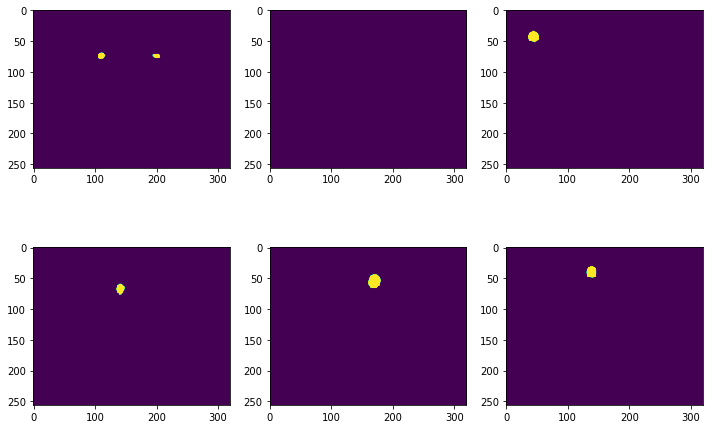

In [27]:
show_pics(output.reshape((24, 256, 320)), 3, 2)

In [28]:
tmp_2 = classes.numpy()

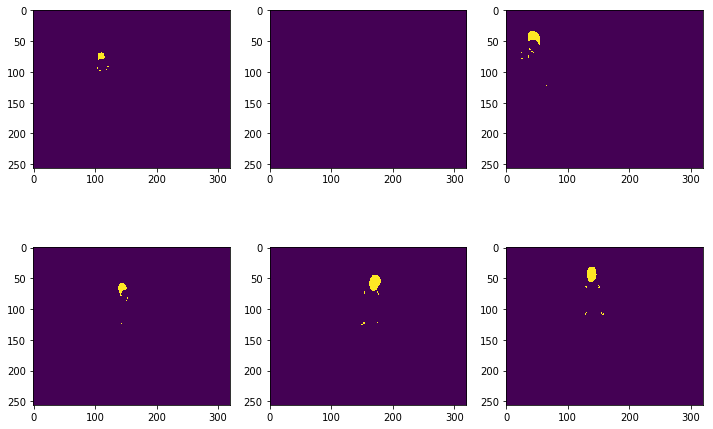

In [29]:
show_pics(tmp_2.reshape(-1, 256, 320), 3, 2)

## NClasses Unet

In [16]:
#https://github.com/milesial/Pytorch-UNet/blob/master/unet
class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            double_conv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x


class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()

        #  would be a nice idea if the upsampling could be learned too,
        #  but my machine do not have enough memory to handle all those weights
        if bilinear:
            self.up = nn.Upsample(scale_factor=2)
        else:
            self.up = nn.ConvTranspose2d(in_ch, out_ch, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffX = x1.size()[2] - x2.size()[2]
        diffY = x1.size()[3] - x2.size()[3]
        x2 = F.pad(x2, (diffX // 2, int(diffX / 2),
                        diffY // 2, int(diffY / 2)))
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x


class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inc = inconv(n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256)
        self.up2 = up(512, 128)
        self.up3 = up(256, 64)
        self.up4 = up(128, 64)
        self.outc = outconv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return x

In [17]:
model = UNet(3, 25)

In [18]:
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    patience=1,
    verbose=True,
    threshold=0.01
)

In [19]:
dset_train_1 = SURREALDataset('/home/novikov/data/skoltech/segmentation/SURREAL/data/sur/SURREAL/data/cmu/train/run0', 10000, True)
dset_test_1 = SURREALDataset('/home/novikov/data/skoltech/segmentation/SURREAL/data/sur/SURREAL/data/cmu/test/run0',  10000, True)
dset_val_1 = SURREALDataset('/home/novikov/data/skoltech/segmentation/SURREAL/data/sur/SURREAL/data/cmu/val/run0', 10000, True)

batch_sz = 16
train_loader = DataLoader(dset_train_1, batch_size=batch_sz, shuffle=False)
test_loader = DataLoader(dset_test_1, batch_size=batch_sz, shuffle=True)
val_loader = DataLoader(dset_val_1, batch_size=batch_sz, shuffle=True)

HBox(children=(IntProgress(value=0, max=1967), HTML(value='')))

HBox(children=(IntProgress(value=0, max=704), HTML(value='')))

HBox(children=(IntProgress(value=0, max=174), HTML(value='')))

In [20]:
loss_tr = []
loss_val = []
gpu = torch.cuda.is_available()
for epoch in range(5):
    loss_tr.append(train(epoch))
    loss_val.append(validate())
torch.save(model.state_dict(), 'pytorch_segm_model_2')

RuntimeError: $ Torch: not enough memory: you tried to allocate 7GB. Buy new RAM! at /opt/conda/conda-bld/pytorch_1512386481460/work/torch/lib/TH/THGeneral.c:246